### Big change to V3: we only predict 2009-01 thru 2013-12 because of cap change: https://www.eia.gov/todayinenergy/detail.php?id=14851

In [1]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep_v2, AugSynthGPT
from my_pysyncon.utils import PlaceboTest, date_to_str, winsorize_series_preserve_nans
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data
df_mo = pd.read_csv('../../../SharedData/total_state_data_orig.csv')

# remove data post-2014-01-01
df = df_mo[df_mo['date'] < '2014-01-01']

In [3]:
# this list is used to make certain columns later
abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [4]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)
df_mo['co2_per_capita'] = (df_mo['monthly_emissions'] / df_mo['monthly_population'])
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp']*10000 / df_mo['monthly_population']
df_mo['eprod_per_capita'] = (df_mo['monthly_energy_prod'] / df_mo['monthly_population'])
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
df_mo['avg_facility_age'] = (df_mo['total_facility_age']/100)/df_mo['monthly_num_plants']
df_mo['avg_weighted_facility_age'] = (df_mo['total_weighted_facility_age'])/(10**7)/df_mo['monthly_num_plants'] 

# winsorize snow, energy use, and renewable energy %
df_mo['snow_wnsr'] = winsorize_series_preserve_nans(df_mo['snow'], limits=[0.00, 0.15])
df_mo['euse_per_capita_wnsr'] = winsorize_series_preserve_nans(df_mo['euse_per_capita'], limits=[0.00, 0.05])
df_mo['monthly_renew_pct_wnsr'] = winsorize_series_preserve_nans(df_mo['monthly_renew_pct'], limits=[0.00, 0.05])

print(df_mo['euse_per_capita'].describe())
print(df_mo['euse_per_capita_wnsr'].describe())
print(df_mo['snow'].describe())
print(df_mo['snow_wnsr'].describe())
print(df_mo['monthly_renew_pct'].describe())
print(df_mo['monthly_renew_pct_wnsr'].describe())

df_mo['monthly_pop_density_log'] = np.log(df_mo['monthly_pop_density'])
df_mo['co2_per_capita_log'] = np.log(df_mo['co2_per_capita'])
df_mo['euse_per_capita_log'] = np.log(df_mo['euse_per_capita'])
df_mo['gdp_per_capita_log'] = np.log(df_mo['gdp_per_capita'])
df_mo['monthly_pop_density_log'] = np.log(df_mo['monthly_pop_density'])
df_mo['snow_wnsr_log'] = np.log1p(df_mo['snow_wnsr'])
df_mo['monthly_renew_pct_wnsr_log'] = np.log1p(df_mo['monthly_renew_pct_wnsr'])

sma_feature_list = ['monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'total_facility_age',
       'monthly_energy_total', 'yearly_energy_total', 'monthly_energy_renew',
       'yearly_energy_renew', 'monthly_renew_pct', 'yearly_renew_pct',
       'monthly_energy_fossil', 'yearly_energy_fossil', 'monthly_fossil_pct',
       'yearly_fossil_pct','monthly_energy_coal', 'yearly_energy_coal', 'monthly_coal_pct',
       'yearly_coal_pct', 'co2_per_capita',
       'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita',
       'euse_per_capita', 'avg_facility_age', 'total_weighted_facility_age','avg_weighted_facility_age','monthly_pop_density_log','co2_per_capita_log',
       'euse_per_capita_log','gdp_per_capita_log','monthly_pop_density_log','snow_wnsr','snow_wnsr_log','euse_per_capita_wnsr','monthly_renew_pct_wnsr_log']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)
df_mo['co2_per_capita_sma']= np.nan
ma_window = 6

for feature in sma_feature_list:
    for state in abbreviations:
        df_mo.loc[df_mo.state==state,feature+str('_sma')] = df_mo.loc[df_mo.state==state,feature].rolling(window=ma_window).mean()

count    17040.000000
mean         0.029005
std          0.012053
min          0.013865
25%          0.021356
50%          0.026473
75%          0.032486
max          0.081241
Name: euse_per_capita, dtype: float64
count    17040.000000
mean         0.028088
std          0.008969
min          0.013865
25%          0.021356
50%          0.026473
75%          0.032486
max          0.053809
Name: euse_per_capita_wnsr, dtype: float64
count    17281.000000
mean         2.421307
std          6.816829
min          0.000000
25%          0.000000
50%          0.000000
75%          0.700000
max         95.800000
Name: snow, dtype: float64
count    17281.000000
mean         0.944309
std          1.727677
min          0.000000
25%          0.000000
50%          0.000000
75%          0.700000
max          4.600000
Name: snow_wnsr, dtype: float64
count    19056.000000
mean         0.144646
std          0.216747
min          0.000000
25%          0.016443
50%          0.049679
75%          0.162281
ma

In [5]:
features = ['eprod_per_capita_sma', 'euse_per_capita_sma', 'gdp_per_capita_sma','monthly_pop_density_sma','snow_sma', 'monthly_coal_pct_sma', 'avg_weighted_facility_age_sma', 'monthly_renew_pct_sma']

for feature in features:
    # Create a new column for the Box–Cox transformed values; initialize with NaN so that rows with missing values remain intact.
    df_mo[feature+'_boxcox'] = np.nan

    # Identify rows where 'eprod_per_capita_sma' is not missing.
    non_na_mask = df_mo[feature].notna()

    # Extract the non-missing values.
    values = df_mo.loc[non_na_mask, feature]

    # Check the minimum value among non-missing entries.
    min_val = values.min()
    print("Minimum value (non-NA) before shift:", min_val)

    # If the minimum value is <= 0, shift all values by (abs(min_val) + a small constant)
    if min_val <= 0:
        offset = abs(min_val) + 1e-6
        values_shifted = values + offset
    else:
        values_shifted = values.copy()

    # Verify that all values are now positive.
    if (values_shifted <= 0).any():
        raise ValueError("There are still non-positive values after shifting!")
    else:
        print("All non-NA values are now positive.")

    # Apply the Box–Cox transformation to the shifted non-missing values.
    values_boxcox, lambda_bc = boxcox(values_shifted)
    print("Optimal lambda for Box–Cox transformation pf", feature,"is:", lambda_bc)

    # Assign the transformed values back to the new column, keeping the original row indices intact.
    df_mo.loc[non_na_mask, feature+'_boxcox'] = values_boxcox


Minimum value (non-NA) before shift: 8.469311642619983e-05
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf eprod_per_capita_sma is: -0.04595888882117683
Minimum value (non-NA) before shift: 0.013917657799429245
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf euse_per_capita_sma is: -0.8170888655098872
Minimum value (non-NA) before shift: 26.260667860162837
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf gdp_per_capita_sma is: -0.4943751441300562
Minimum value (non-NA) before shift: 0.0009419641237163
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf monthly_pop_density_sma is: -0.06334457051028106
Minimum value (non-NA) before shift: 0.0
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf snow_sma is: 0.07371069323921015
Minimum value (non-NA) before shift: -0.0001312751119214762
All non-NA values are now positive.
Optimal lambda

In [6]:
# scale certain features 

# apply boxcox to certain features to reduce skewness
df_mo['eprod_per_capita_sma_boxcox'] = df_mo['eprod_per_capita_sma_boxcox']/10
df_mo['euse_per_capita_sma'] = df_mo['euse_per_capita_sma']*10
df_mo['tavg_sma'] = df_mo['tavg_sma']/100
df_mo['monthly_pop_density_sma_boxcox'] = df_mo['monthly_pop_density_sma_boxcox'] /10
df_mo['gdp_per_capita_sma_boxcox'] = df_mo['gdp_per_capita_sma_boxcox']
df_mo['snow'] = df_mo['snow']/10

In [7]:
# take log of certain features after applying sma to reduce skewness
df_mo['co2_per_capita_sma_log'] = np.log(df_mo['co2_per_capita_sma'])
df_mo['euse_per_capita_sma_log'] = np.log(df_mo['euse_per_capita_sma'])
df_mo['gdp_per_capita_sma_log'] = np.log(df_mo['gdp_per_capita_sma'])
df_mo['monthly_pop_density_sma_log'] = np.log(df_mo['monthly_pop_density_sma'])
df_mo['monthly_renew_pct_sma_log'] = np.log1p(df_mo['monthly_renew_pct_sma'])

In [8]:
# RGGI's first auction was 2009-01, and pre-treatment data extends back to 1990-01.
treatment_date = '2009-01-01'
start_date = '1999-01-01'
preintervention_ma_start_date = str((pd.to_datetime(start_date)+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))

# these are the time values where our pre-treatment features and CO2 outcomes are fit
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2013-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

In [9]:
# these are the features can be box-coxed to reduce skewness
#box_cox_feats = ['eprod_per_capita_sma', 'euse_per_capita_sma', 'gdp_per_capita_sma','monthly_pop_density_sma','snow_sma', 'monthly_coal_pct_sma', 'avg_weighted_facility_age_sma', 'monthly_renew_pct_sma']
box_cox_feats = ['co2_per_capita_sma']

# correct date formatting for masks below
df_mo['date_dt'] = pd.to_datetime(df_mo['date'])

# make masks for pre- and post-treatment, and drop na values
pre_mask = df_mo['date_dt'] < pd.to_datetime("2009-01-01")
post_mask = df_mo['date_dt'] >= pd.to_datetime("2009-01-01")

for feat in box_cox_feats:
    # debugging print
    print('feature is', feat)
    print('min is,', df_mo[feat].min())

    trans_feat = feat+'_boxcox'
    # initialize box-cox column
    df_mo[trans_feat] = np.nan

    # ----------------------------
    # PRE-TREATMENT TRANSFORMATION
    # ----------------------------
    # get pre-treatment values and drop null values
    pre_values = df_mo.loc[pre_mask, feat].dropna()
    
    min_val = pre_values.min()
    print("Minimum value (non-NA) before shift:", min_val)

    # introduce offset if needed; box–cox requires values > 0.
    if min_val <= 0:
        offset = abs(min_val) + 1e-6
    else:
        offset = 0.0

    # shift by offset
    pre_values_shifted = pre_values + offset

    # verify that all pre-values are now positive
    if ( pre_values_shifted <= 0).any():
        raise ValueError("There are still non-positive values after shifting!")

    # apply box-cox
    transformed_pre, lambda_bc = boxcox(pre_values_shifted)
    print("Optimal lambda for Box–Cox transformation is:", lambda_bc)

    # store transformed values
    df_mo.loc[pre_mask & df_mo[feat].notna(), trans_feat] = transformed_pre

    # -----------------------------
    # POST-TREATMENT TRANSFORMATION
    # -----------------------------
    # apply box-cox with given lambda (from pre-treatment box-cox above)
    def apply_boxcox(x, lam, offset):
        x_shifted = x + offset
        #print('offset is', offset)
        #print('old min is', x.min())
        #print('new shifted min is', x_shifted.min())
        # verify that all values are now positive
        if (x_shifted <= 0).any():
            raise ValueError("There are still non-positive values after shifting!")
        else:
            print("All non-NA values are now positive.")
        
        if lam == 0:
            return np.log(x_shifted)
        else:
            return (np.power(x_shifted, lam) - 1) / lam

    # get post-treatment values, drop null values, and apply box-cox with pre-treatment lambda
    post_values = df_mo.loc[post_mask, feat].dropna()
    transformed_post = apply_boxcox(post_values, lambda_bc, offset)

    # store transformed values
    df_mo.loc[post_mask & df_mo[feat].notna(), trans_feat] = transformed_post


feature is co2_per_capita_sma
min is, 2.054023816616329e-06
Minimum value (non-NA) before shift: 2.054023816616329e-06
Optimal lambda for Box–Cox transformation is: 0.2511531387086594
All non-NA values are now positive.


In [10]:
# we exclude non-RGGI states with no CO2 data (AK, HI); states with some strong emissions program (CA, WA, OR, MN, IL); states with high CO2 increase post-treatment (ID by +67%)
# we exclude RGGI states with partial RGGI participation (NJ), and those without coal-fired power plants (VT, RI)
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NY']    

non_rggi_controls_identifier = ["AL", "AR", "AZ", "CO", "FL", "GA", "IN", "IA", "KS", "KY", "LA", "MI", 
                               "MS", "MO", "MT", "NJ", "NE", "NV", "NM", "NC", "ND", "OH", "OK", "PA", 
                               "SC", "SD", "TN", "TX", "UT", "VA", "WV", "WI", "WY"
                            ]

In [11]:
# these lists are used for treatment_time in graphs below
treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

# this date format is needed to specify time ranges in Dataprep below
preintervention_ma_range_dt = pd.to_datetime(preintervention_ma_range)

NJ    0.512
SD    0.321
VA    0.194
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.022358734233490215


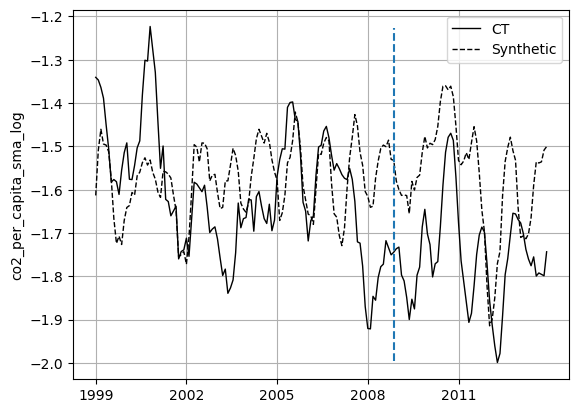

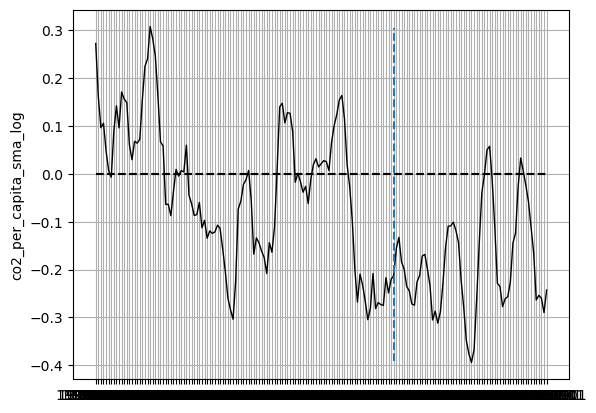

Now performing placebo test for: CT
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for MS.
(6/33) Completed placebo test for KY.
(7/33) Completed placebo test for KS.
(8/33) Completed placebo test for MO.
(9/33) Completed placebo test for IN.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for ND.
(12/33) Completed placebo test for NE.
(13/33) Completed placebo test for AL.
(14/33) Completed placebo test for NV.
(15/33) Completed placebo test for SD.
(16/33) Completed placebo test for MI.
(17/33) Completed placebo test for LA.
(18/33) Completed placebo test for PA.
(19/33) Completed placebo test for WY.
(20/33) Completed placebo test for IA.
(21/33) Completed placebo test for GA.
(22/33) Completed placebo test for UT.
(23/33) Completed placebo test for TN.
(24/33) Completed placebo test for OH.
(25/33) Completed placebo test for AZ

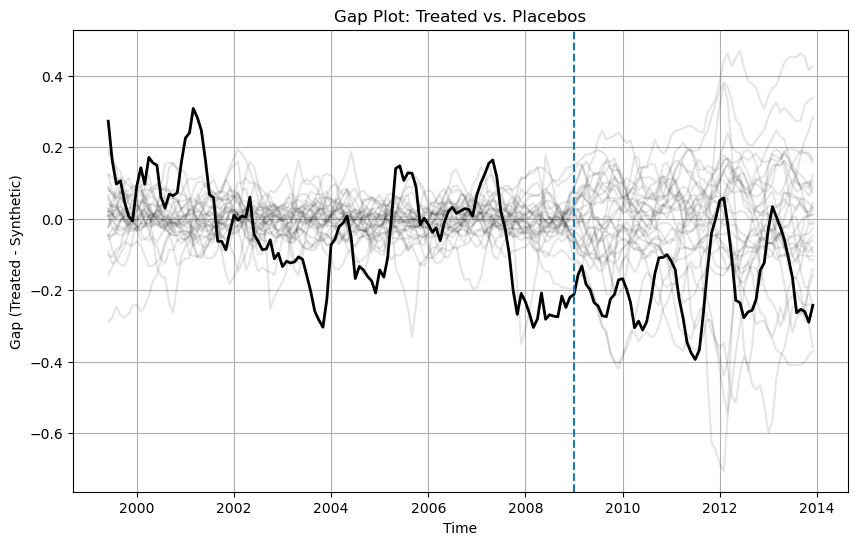

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
IA    0.302
NJ    0.209
NV    0.485
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.02391382510807791


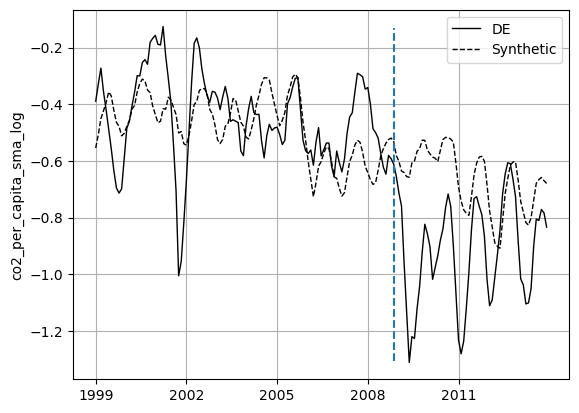

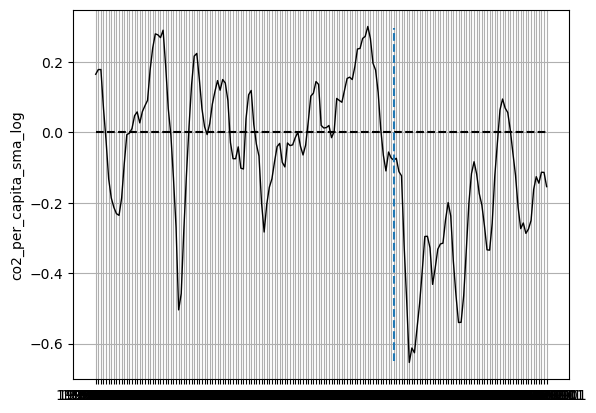

Now performing placebo test for: DE
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for MS.
(6/33) Completed placebo test for KS.
(7/33) Completed placebo test for KY.
(8/33) Completed placebo test for MO.
(9/33) Completed placebo test for IN.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for NE.
(12/33) Completed placebo test for NV.
(13/33) Completed placebo test for ND.
(14/33) Completed placebo test for AL.
(15/33) Completed placebo test for MI.
(16/33) Completed placebo test for LA.
(17/33) Completed placebo test for SD.
(18/33) Completed placebo test for PA.
(19/33) Completed placebo test for IA.
(20/33) Completed placebo test for WY.
(21/33) Completed placebo test for GA.
(22/33) Completed placebo test for TN.
(23/33) Completed placebo test for UT.
(24/33) Completed placebo test for AZ.
(25/33) Completed placebo test for OH

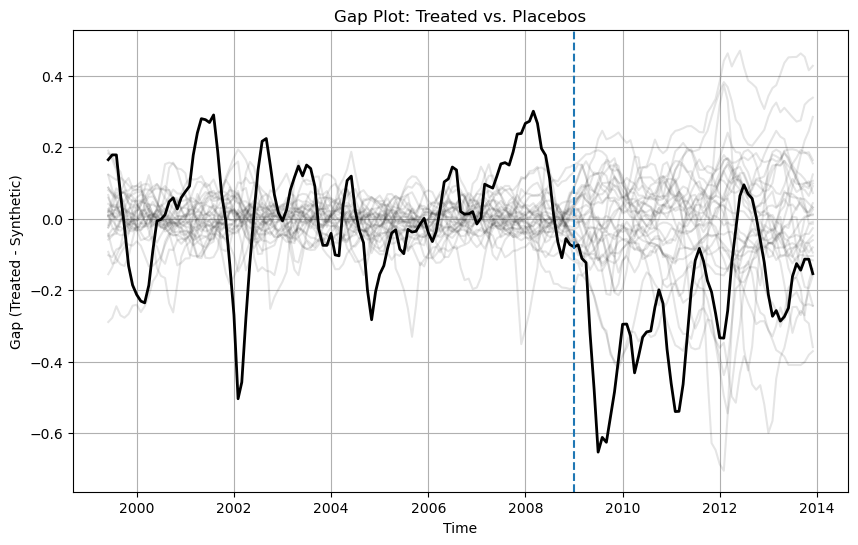

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
NJ    0.448
SD    0.500
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.09890665545826112


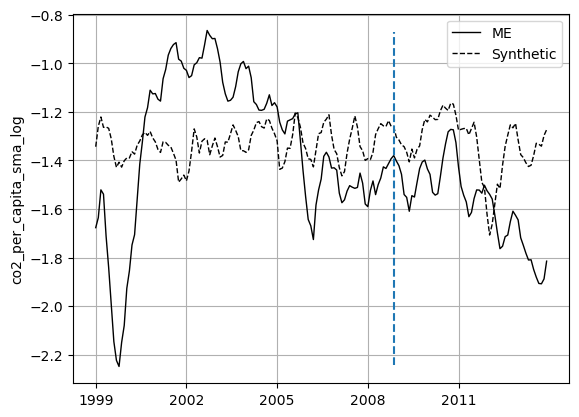

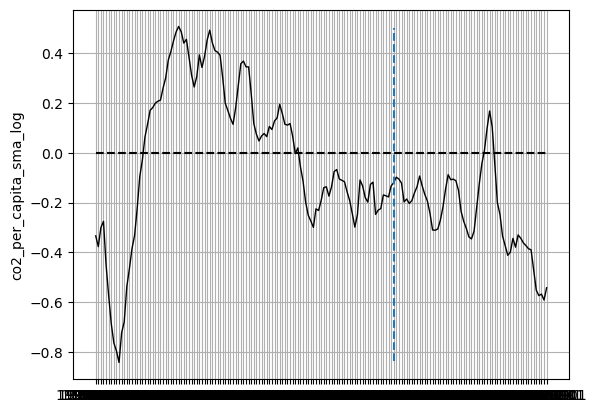

Now performing placebo test for: ME
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for KY.
(6/33) Completed placebo test for KS.
(7/33) Completed placebo test for MS.
(8/33) Completed placebo test for MO.
(9/33) Completed placebo test for IN.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for NE.
(12/33) Completed placebo test for ND.
(13/33) Completed placebo test for NV.
(14/33) Completed placebo test for AL.
(15/33) Completed placebo test for MI.
(16/33) Completed placebo test for SD.
(17/33) Completed placebo test for LA.
(18/33) Completed placebo test for WY.
(19/33) Completed placebo test for PA.
(20/33) Completed placebo test for IA.
(21/33) Completed placebo test for GA.
(22/33) Completed placebo test for TN.
(23/33) Completed placebo test for UT.
(24/33) Completed placebo test for OH.
(25/33) Completed placebo test for AZ

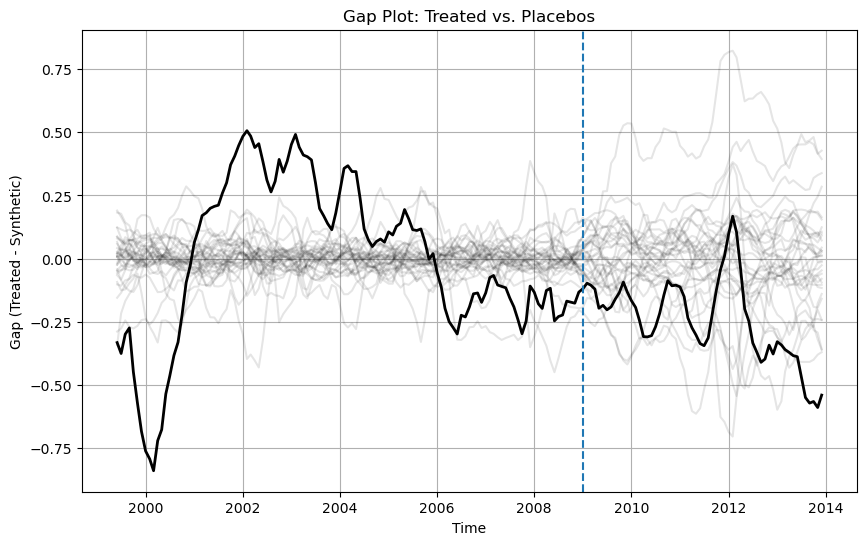

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
NJ    0.321
OH    0.217
TN    0.187
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.014376865536340303


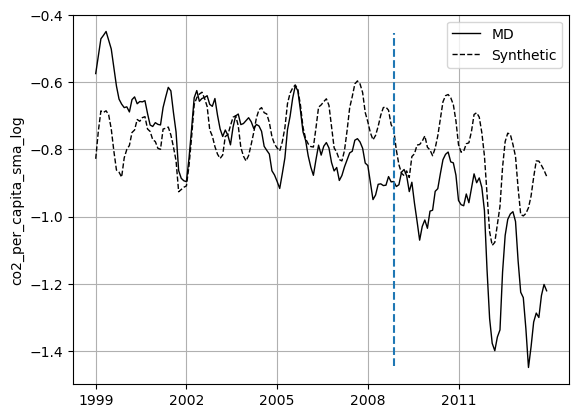

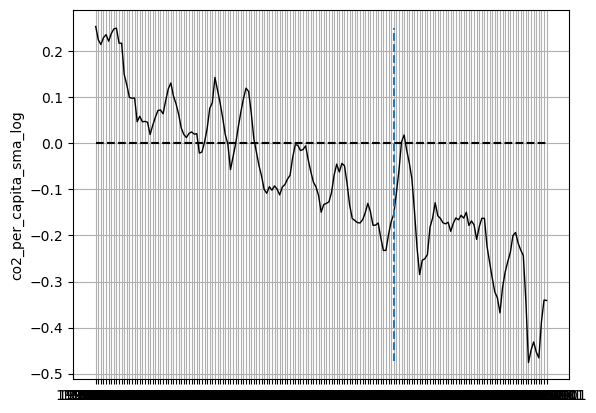

Now performing placebo test for: MD
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for KS.
(6/33) Completed placebo test for MS.
(7/33) Completed placebo test for KY.
(8/33) Completed placebo test for MO.
(9/33) Completed placebo test for IN.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for AL.
(12/33) Completed placebo test for ND.
(13/33) Completed placebo test for NE.
(14/33) Completed placebo test for NV.
(15/33) Completed placebo test for LA.
(16/33) Completed placebo test for SD.
(17/33) Completed placebo test for MI.
(18/33) Completed placebo test for PA.
(19/33) Completed placebo test for WY.
(20/33) Completed placebo test for GA.
(21/33) Completed placebo test for IA.
(22/33) Completed placebo test for OH.
(23/33) Completed placebo test for UT.
(24/33) Completed placebo test for TN.
(25/33) Completed placebo test for SC

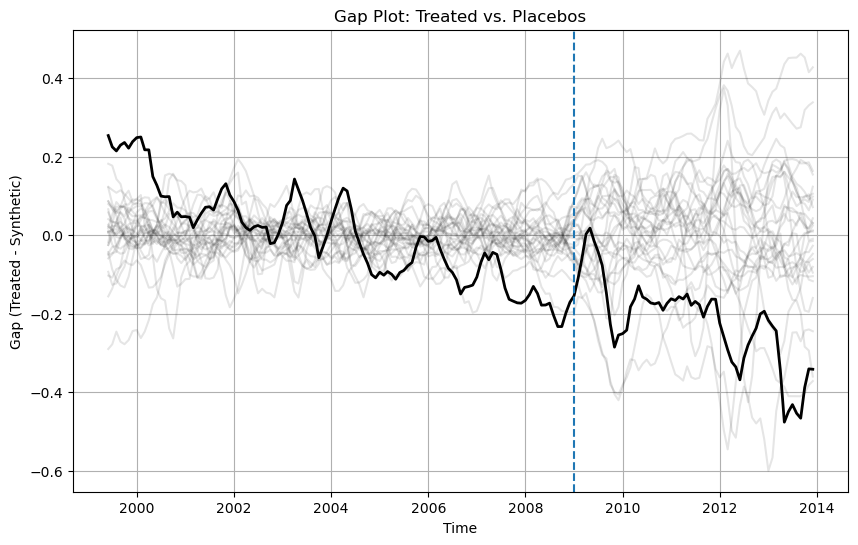

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
MT    0.168
NJ    0.482
SD    0.349
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.007549501146788674


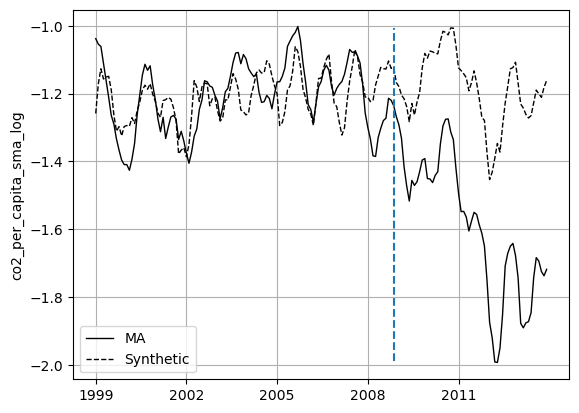

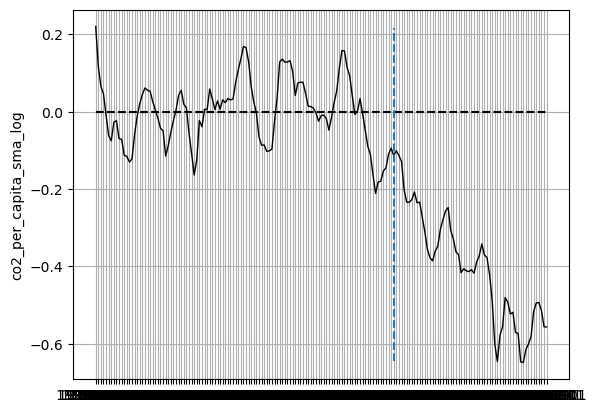

Now performing placebo test for: MA
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for KS.
(6/33) Completed placebo test for MS.
(7/33) Completed placebo test for KY.
(8/33) Completed placebo test for IN.
(9/33) Completed placebo test for CO.
(10/33) Completed placebo test for MO.
(11/33) Completed placebo test for NE.
(12/33) Completed placebo test for ND.
(13/33) Completed placebo test for AL.
(14/33) Completed placebo test for NV.
(15/33) Completed placebo test for SD.
(16/33) Completed placebo test for MI.
(17/33) Completed placebo test for LA.
(18/33) Completed placebo test for IA.
(19/33) Completed placebo test for PA.
(20/33) Completed placebo test for WY.
(21/33) Completed placebo test for GA.
(22/33) Completed placebo test for TN.
(23/33) Completed placebo test for UT.
(24/33) Completed placebo test for WV.
(25/33) Completed placebo test for AZ

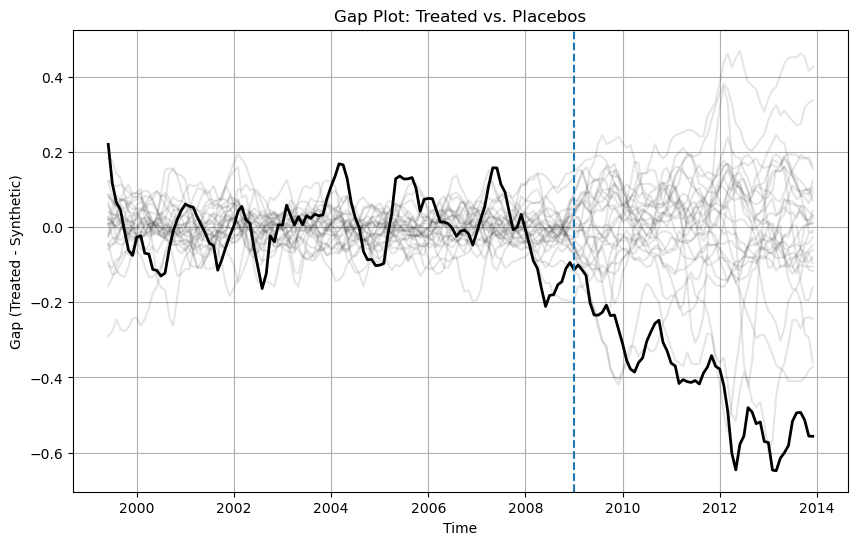

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
MT    0.466
NJ    0.503
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.036662861581311164


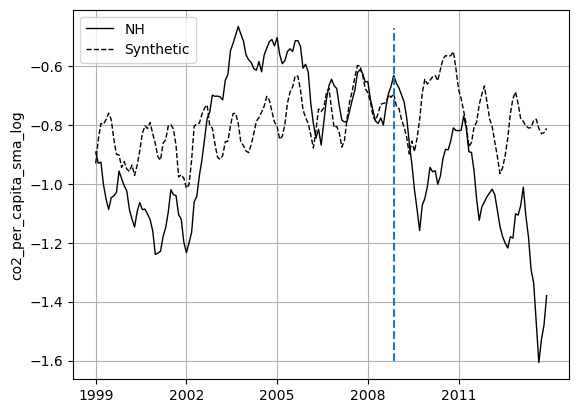

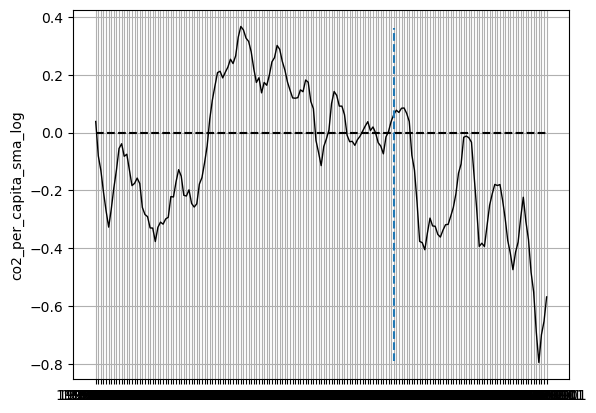

Now performing placebo test for: NH
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for KS.
(6/33) Completed placebo test for KY.
(7/33) Completed placebo test for MS.
(8/33) Completed placebo test for IN.
(9/33) Completed placebo test for MO.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for NE.
(12/33) Completed placebo test for ND.
(13/33) Completed placebo test for AL.
(14/33) Completed placebo test for NV.
(15/33) Completed placebo test for MI.
(16/33) Completed placebo test for LA.
(17/33) Completed placebo test for SD.
(18/33) Completed placebo test for PA.
(19/33) Completed placebo test for IA.
(20/33) Completed placebo test for WY.
(21/33) Completed placebo test for UT.
(22/33) Completed placebo test for GA.
(23/33) Completed placebo test for TN.
(24/33) Completed placebo test for OH.
(25/33) Completed placebo test for AZ

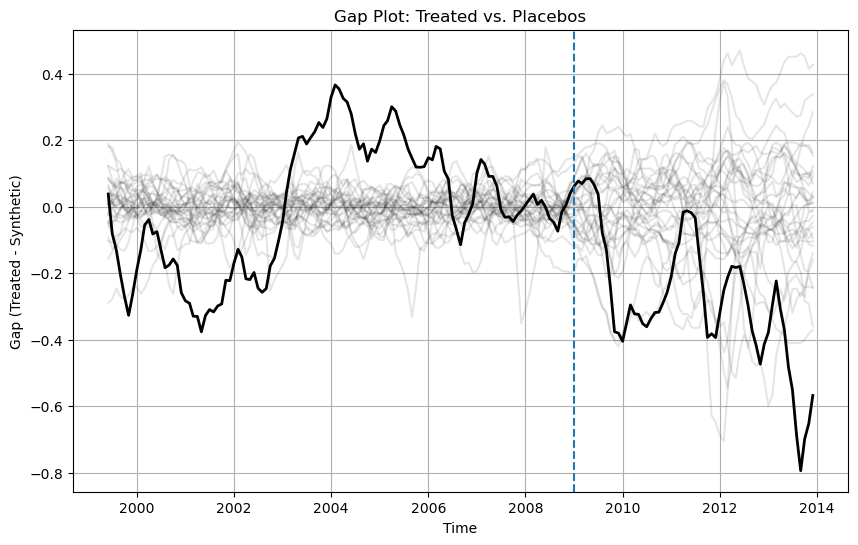

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
NJ    0.500
SD    0.223
VA    0.280
Name: weights, dtype: float64
Regularization lambda = 218.46323964047764
Pre-treatment MSE = 0.01097372266484713


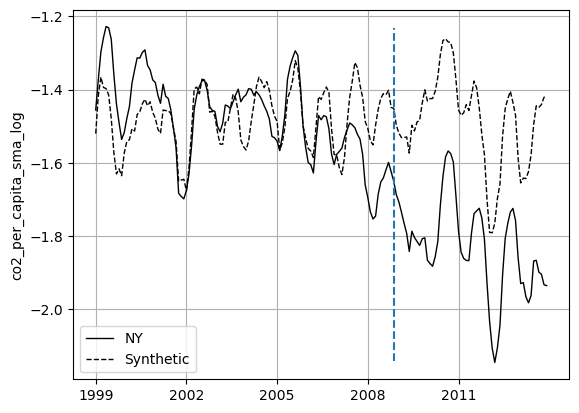

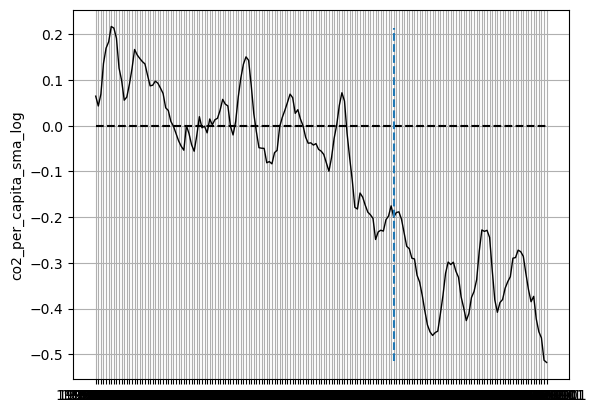

Now performing placebo test for: NY
(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for MS.
(6/33) Completed placebo test for KS.
(7/33) Completed placebo test for KY.
(8/33) Completed placebo test for IN.
(9/33) Completed placebo test for MO.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for ND.
(12/33) Completed placebo test for NE.
(13/33) Completed placebo test for AL.
(14/33) Completed placebo test for NV.
(15/33) Completed placebo test for SD.
(16/33) Completed placebo test for PA.
(17/33) Completed placebo test for LA.
(18/33) Completed placebo test for MI.
(19/33) Completed placebo test for IA.
(20/33) Completed placebo test for GA.
(21/33) Completed placebo test for WY.
(22/33) Completed placebo test for TN.
(23/33) Completed placebo test for UT.
(24/33) Completed placebo test for OH.
(25/33) Completed placebo test for AZ

KeyboardInterrupt: 

In [12]:
# create a Dataprep object which contains information about covariates/predictors and outcomes/dependents
# time

for state in rggi_states:
    dataprep_mo_ma = Dataprep_v2(
        foo = df_mo,
        predictors = [],
        predictors_op = "mean",
        time_predictors_prior = preintervention_ma_range,
        special_predictors=[
            ('avg_weighted_facility_age_sma_boxcox',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year ==2008)&((preintervention_ma_range_dt.dt.month ==6)|(preintervention_ma_range_dt.dt.month ==12))]), 'mean'),
            ('snow_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),            
            ('co2_per_capita_sma_log', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= 1998) & (preintervention_ma_range_dt.dt.year <= 2008) &(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
            ('monthly_pop_density_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998) & (preintervention_ma_range_dt.dt.year<=2008)]), "mean"),                         
            ('eprod_per_capita_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),  
            ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'), 
            ('monthly_renew_pct_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),
            ('gdp_per_capita_sma_boxcox',  date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998)& (preintervention_ma_range_dt.dt.year<=2008)]), 'mean'),
            ('monthly_coal_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
            ('euse_per_capita_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
            ],
        dependent="co2_per_capita_sma_log",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )

    # fit the model
    synth_mo_ma = AugSynthGPT()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)
    print(synth_mo_ma.weights(threshold = .1))
    print('Regularization lambda =', synth_mo_ma.lambda_)
    print('Pre-treatment MSE =', synth_mo_ma.mspe(Z0=synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))

    # plot the synthetic vs actual
    synth_mo_ma.path_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0])

    # display the V matrix weights and distribution info
    synth_mo_ma.summary_with_variance(round=3)

    # perform the placebo tests
    print('Now performing placebo test for:', state)
    placebo_test = PlaceboTest()
    placebo_test.fit(
        dataprep=dataprep_mo_ma,
        scm=synth_mo_ma,
        scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
    )

    # plot the placebo tests
    print('The p-value for',state,'is',placebo_test.pvalue(treatment_time = treatment_dates_ma[0]))
    placebo_test.gaps_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0], mspe_threshold=1)

    print('-------------------------------------------------------------------------------------------------------------------------')
    print('NEXT STATE')
    print('-------------------------------------------------------------------------------------------------------------------------')